# **Libraries**

In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# **Data loading and exploration**

In [2]:
fpath = '../Dataset'
random_seed = 9

categories = os.listdir(fpath)
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))

List of categories =  ['closed', 'open'] 

No. of categories =  2


In [3]:
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            img_array = Image.fromarray(img, 'RGB')
            
            img_lst.append(np.array(img_array))
            
            labels.append(index)
    return img_lst, labels

images, labels = load_images_and_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))

No. of images loaded =  2422 
No. of labels loaded =  2422
<class 'list'> <class 'list'>


In [4]:
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (2422, 24, 24, 3) 
Labels shape =  (2422,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


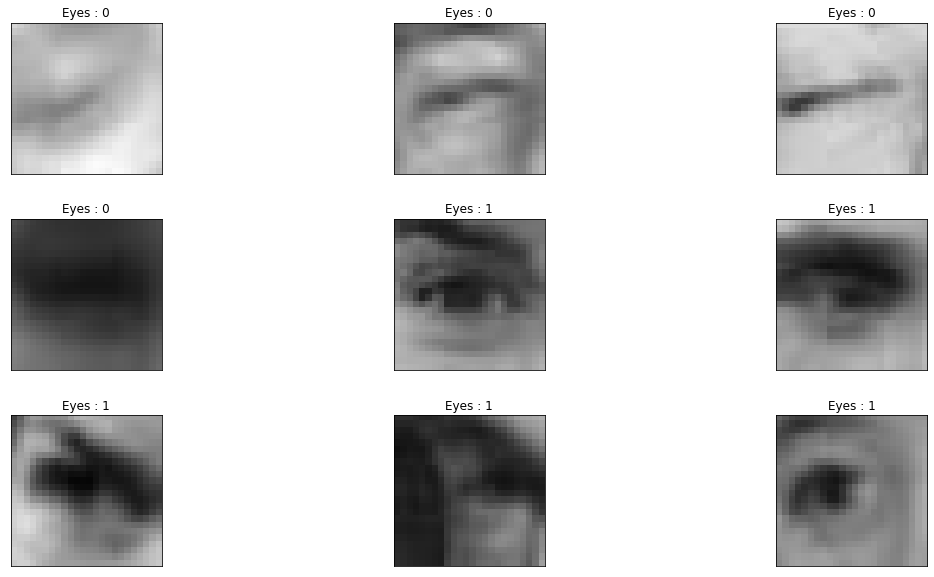

In [5]:
def display_rand_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        plt.title('Eyes : {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    
display_rand_images(images, labels)


# **Prepare data for training the CNN model**

In [6]:
#1-step in data shuffling

#get equally spaced numbers in a given range
n = np.arange(images.shape[0])
print("'n' values before shuffling = ",n)

#shuffle all the equally spaced values in list 'n'
np.random.seed(random_seed)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)

'n' values before shuffling =  [   0    1    2 ... 2419 2420 2421]

'n' values after shuffling =  [ 737 2294  456 ...  501  348  382]


In [7]:
#2-step in data shuffling

#shuffle images and corresponding labels data in both the lists
images = images[n]
labels = labels[n]

print("Images shape after shuffling = ",images.shape,"\nLabels shape after shuffling = ",labels.shape)

Images shape after shuffling =  (2422, 24, 24, 3) 
Labels shape after shuffling =  (2422,)


In [8]:
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (2422, 24, 24, 3)


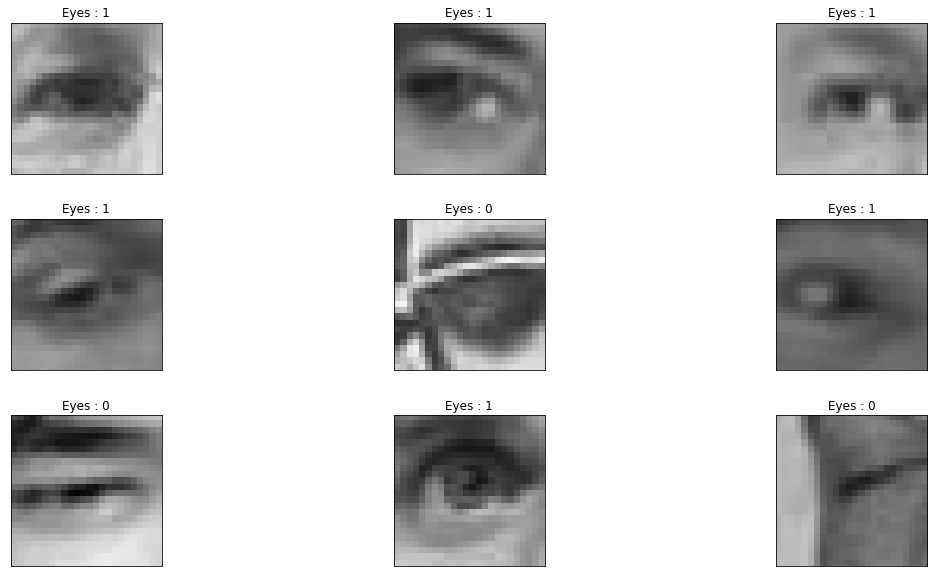

In [9]:
display_rand_images(images, labels)

In [10]:
train_ds, test_ds, train_labels, test_labels = train_test_split(images, labels, test_size = 0.2, random_state = random_seed)

print("train_ds shape = ",train_ds.shape)
print("train_labels shape = ",train_labels.shape)
print("\ntest_ds shape = ",test_ds.shape)
print("test_labels shape = ",test_labels.shape)

train_ds shape =  (1937, 24, 24, 3)
train_labels shape =  (1937,)

test_ds shape =  (485, 24, 24, 3)
test_labels shape =  (485,)


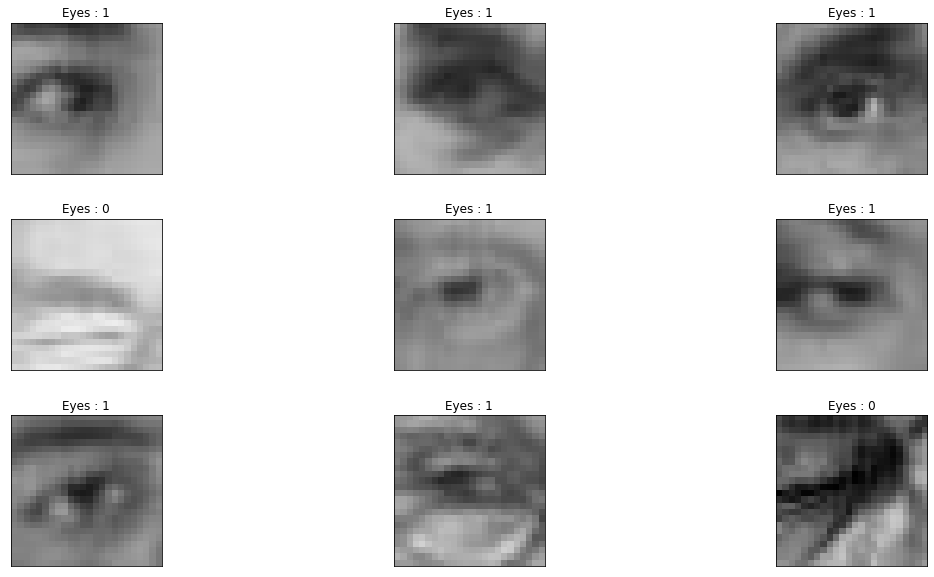

In [11]:
display_rand_images(train_ds, train_labels)

In [12]:
## Resizing images
train_ds = tf.image.resize(train_ds, (150, 150))
test_ds = tf.image.resize(test_ds, (150, 150))

# **Define CNN model**

In [13]:
## Loading VGG19 model
base_model = VGG19(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(train_ds) 
test_ds = preprocess_input(test_ds)

In [14]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [15]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(5, activation='sigmoid')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

# **Train model**

In [16]:
%%time

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

history = model.fit(train_ds, train_labels, epochs=50, validation_split=0.2, batch_size=32)

Epoch 1/50
49/49 [==============================] - 209s 4s/step - loss: 0.7997 - accuracy: 0.4842 - val_loss: 0.6985 - val_accuracy: 0.4691
Epoch 2/50
49/49 [==============================] - 208s 4s/step - loss: 0.6945 - accuracy: 0.5074 - val_loss: 0.6952 - val_accuracy: 0.4691
Epoch 3/50
49/49 [==============================] - 208s 4s/step - loss: 0.6948 - accuracy: 0.4803 - val_loss: 0.6929 - val_accuracy: 0.5309
Epoch 4/50
49/49 [==============================] - 210s 4s/step - loss: 0.6941 - accuracy: 0.4906 - val_loss: 0.6929 - val_accuracy: 0.5309
Epoch 5/50
49/49 [==============================] - 211s 4s/step - loss: 0.6950 - accuracy: 0.4945 - val_loss: 0.6957 - val_accuracy: 0.4691
Epoch 6/50
49/49 [==============================] - 207s 4s/step - loss: 0.6953 - accuracy: 0.4790 - val_loss: 0.6930 - val_accuracy: 0.5309
Epoch 7/50
49/49 [==============================] - 207s 4s/step - loss: 0.6946 - accuracy: 0.5029 - val_loss: 0.6962 - val_accuracy: 0.4691
Epoch 8/50
49

In [17]:
model_json = model.to_json()
with open("VGG19_Eyes_Classifier.json", "w") as json_file:
    json_file.write(model_json)
model.save("VGG19_Eyes_Classifier.h5")
print("Saved model to disk")
model.save_weights("VGG19_Eyes.h5")

Saved model to disk


In [18]:
_, acc = model.evaluate(test_ds, test_labels, verbose=0)

print('> %.2f' % (acc * 100.0))

> 50.93


In [19]:
model_probs = model.predict(test_ds, verbose=0)
y_pred = model_probs
# predict crisp classes for test set
model_classes = np.argmax(model_probs,axis=1)
# reduce to 1d array
model_probs = model_probs[:, 0]
 
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_labels, model_classes)*100
# precision tp / (tp + fp)
precision = precision_score(test_labels, model_classes, average='weighted')*100
# recall: tp / (tp + fn)
recall = recall_score(test_labels, model_classes, average='weighted')*100
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_labels, model_classes, average='weighted')*100

print('Accuracy: %.2f' % accuracy)
print('F1 score: %.2f' % f1)
print('Precision: %.2f' % precision)
print('Recall: %.2f' % recall)

Accuracy: 50.93
F1 score: 34.37
Precision: 25.94
Recall: 50.93


C:\Users\pined\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


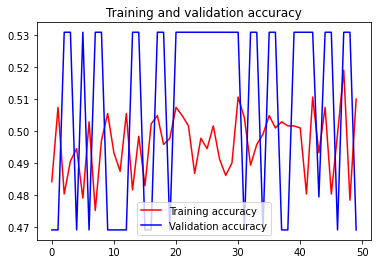

<Figure size 432x288 with 0 Axes>

In [20]:
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [21]:
y_pred.round()

array([[1., 1., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       ...,
       [1., 1., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [1., 1., 0., 0., 0.]], dtype=float32)

In [26]:
Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_pred_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [28]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(test_labels,Y_pred_classes)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[247   0]
 [238   0]]


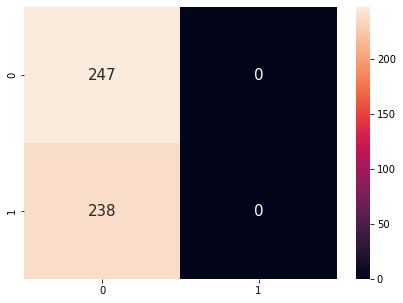

In [29]:
import seaborn as sns
plt.figure(figsize=(7, 5))

sns.heatmap(confusion, annot=True,  annot_kws={'size': 15}, fmt = "d")
plt.show()